In [ ]:
pip install category_encoders

# Import Package & Data

In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import xgboost as xgb
import pickle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import os

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [229]:
df = pd.read_excel("/content/drive/MyDrive/TUBES PASD/Quantity-Prediction Data.xlsx")
df.head()

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Safety Percentage,Event_Demand_Estimated,Location,Latitude,Longitude
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,0.30,515,Makassar,-5.1477,119.4327
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,0.30,262,Surabaya,-7.2575,112.7521
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,0.30,296,Medan,3.5952,98.6722
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,0.15,495,Batam,1.0456,104.0305
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,0.15,288,Batam,1.0456,104.0305


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5678 entries, 0 to 5677
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    5677 non-null   datetime64[ns]
 1   Kategori                5677 non-null   object        
 2   Tipe/Model              5677 non-null   object        
 3   Demand                  5677 non-null   float64       
 4   Past_Demand_1           5677 non-null   float64       
 5   Past_Demand_2           5677 non-null   float64       
 6   Moving_Average          5677 non-null   float64       
 7   Sales_Trend             5678 non-null   float64       
 8   Event                   5677 non-null   object        
 9   Event_Multiplier        5677 non-null   float64       
 10  Safety Percentage       5677 non-null   float64       
 11  Event_Demand_Estimated  5678 non-null   int64         
 12  Location                5678 non-null   object  

In [231]:
df.isnull().sum()

,0
Date,1
Kategori,1
Tipe/Model,1
Demand,1
Past_Demand_1,1
Past_Demand_2,1
Moving_Average,1
Sales_Trend,0
Event,1
Event_Multiplier,1


In [232]:
df[['Demand','Past_Demand_1', 'Past_Demand_2', 'Moving_Average','Sales_Trend','Event_Multiplier', 'Safety Percentage', 'Event_Demand_Estimated']].describe()

,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event_Multiplier,Safety Percentage,Event_Demand_Estimated
count,5677.000000,5677.000000,5677.000000,5677.000000,5678.000000,5677.000000,5677.000000,5678.000000
mean,354.293289,345.274969,340.100581,346.556280,0.263443,1.013158,0.158834,809.007221
std,192.418250,191.069022,190.569962,146.104288,0.938462,0.062493,0.041381,347.005800
min,30.000000,30.000000,25.000000,35.000000,-0.882658,1.000000,0.150000,0.000000
25%,210.000000,203.000000,198.000000,245.333333,-0.304348,1.000000,0.150000,570.000000
50%,315.000000,305.000000,299.000000,326.000000,0.014286,1.000000,0.150000,759.500000
75%,454.000000,444.000000,435.000000,421.666667,0.523490,1.000000,0.150000,984.000000
max,996.000000,996.000000,996.000000,949.333333,8.267606,1.500000,0.450000,2928.000000


In [233]:
df[['Kategori','Tipe/Model','Event','Location']].describe()

,Kategori,Tipe/Model,Event,Location
count,5677,5677,5677,5678
unique,10,46,9,10
top,Vacuum Cleaner,Setrika,No_Event,Makassar
freq,644,632,5421,601


In [234]:
# Menampilkan nilai unik untuk semua kolom kategorik
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Nilai unik di kolom {col}:")
    print(df[col].unique())
    print()  # Line break


Nilai unik di kolom Kategori:
['Dispenser' 'Kipas Angin' 'Setrika' 'Blender' 'Televisi' 'Vacuum Cleaner'
 'Microwave' 'AC (Air Conditioner)' 'Mesin Cuci' 'Kulkas' nan]

Nilai unik di kolom Tipe/Model:
['Dispenser Portable' 'Kipas Berdiri' 'Setrika' 'Blender Kaca'
 'Kipas Meja' 'QLED 65"' 'Canister Vacuum' 'LED 24"' 'Solo Microwave'
 'Grill Microwave' 'Split 0.5 PK' 'Handheld Vacuum' 'Top Loading'
 'Robot Vacuum' 'LED 43"' 'Blender Plastik' 'Portable AC 1 PK'
 'Cassette 2 PK' 'Hot & Cool' 'Twin Tub 9kg' 'Inverter Microwave'
 'Digital Microwave' 'Side-by-side' 'OLED 55"' 'Showcase' 'Kulkas Mini'
 'Smart TV 50"' 'Bottom Loading (Galon Bawah)' 'Wet & Dry Vacuum'
 '2 in 1 Blender' 'Top Load 8kg' '1 Pintu' 'Inverter 2 Pintu'
 'Mini Blender' 'Inverter 9kg' 'Split 1.5 PK Inverter' 'Stick Vacuum'
 'Kipas Remote Control' 'Standing Floor 2.5 PK' 'Top Load 6kg' 'LED 32"'
 'Front Load 10kg' 'Split 1 PK' 'Kipas Dinding' '2 Pintu' 'Front Load 7kg'
 nan]

Nilai unik di kolom Event:
['New_Year' 'No_Eve

In [235]:
num_data = df[['Demand', 'Past_Demand_1', 'Past_Demand_2', 'Moving_Average', 'Sales_Trend', 'Event_Multiplier', 'Safety Percentage', 'Event_Demand_Estimated']]
cat_data = df[['Kategori', 'Tipe/Model', 'Event', 'Location']]

# Visualisasi Data

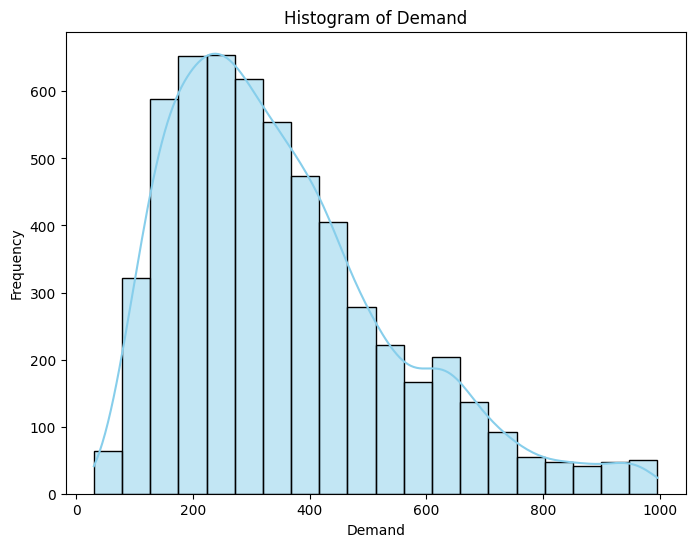

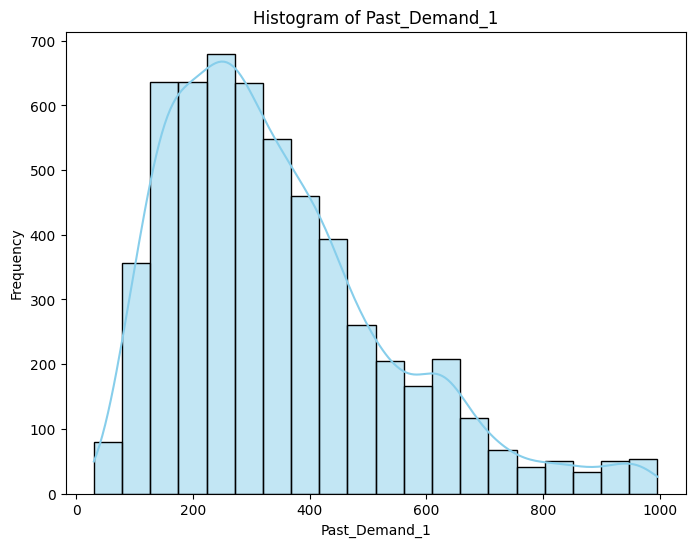

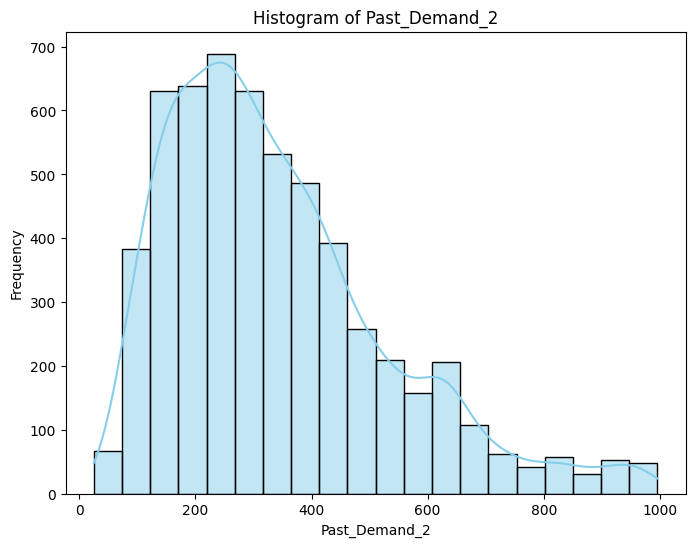

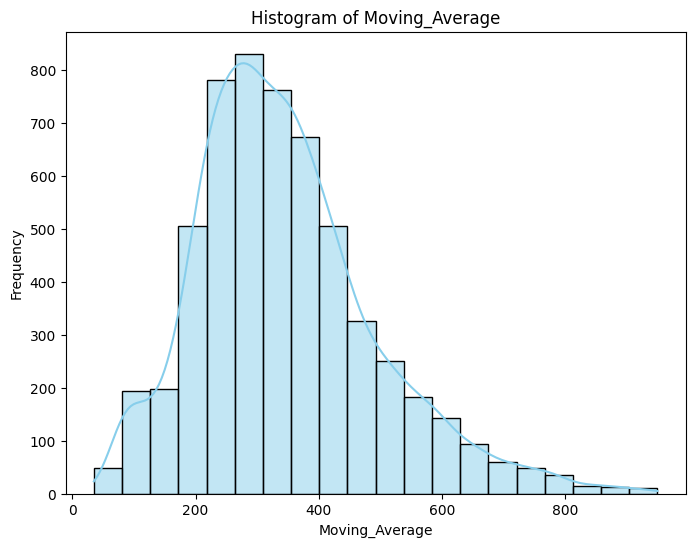

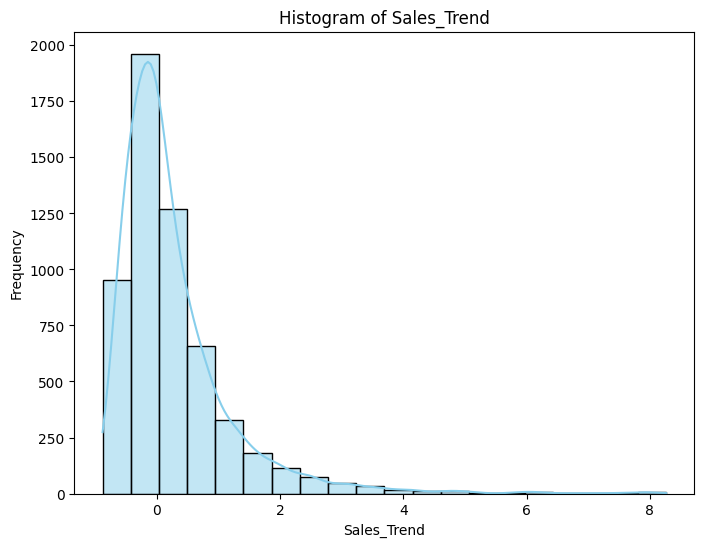

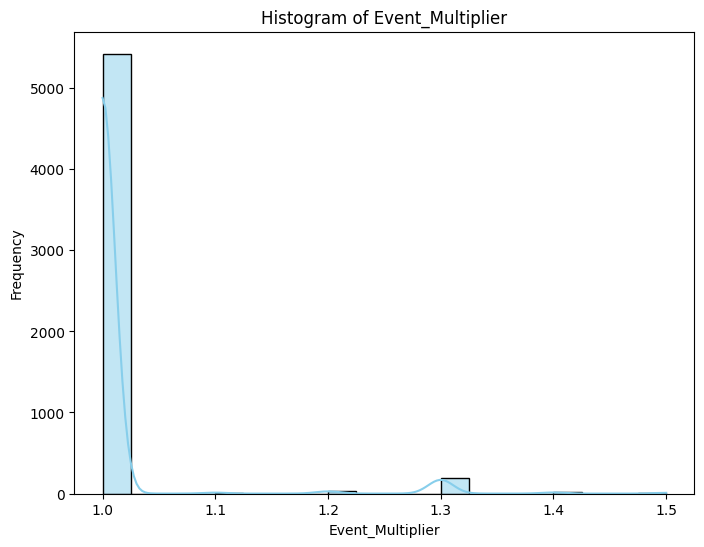

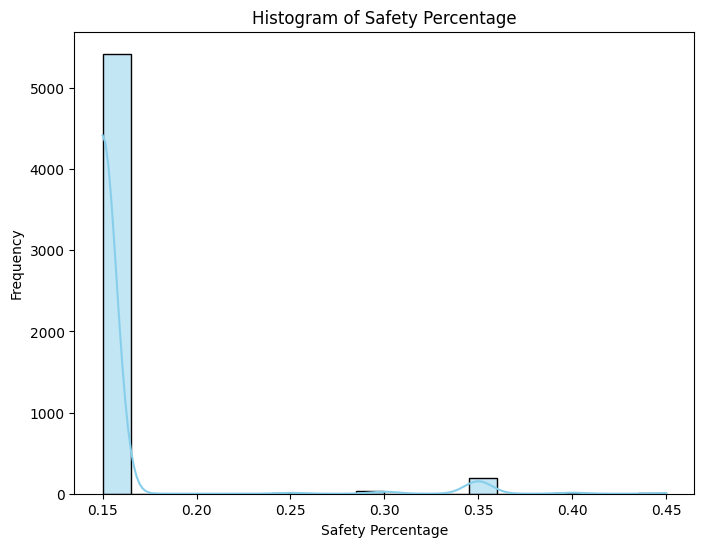

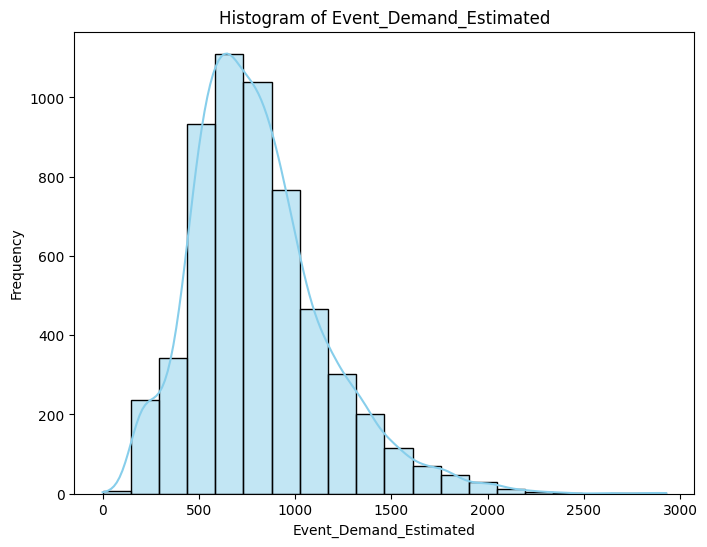

In [236]:
for col in num_data:
  plt.figure(figsize=(8,6))
  sns.histplot(data=df, x=col, kde=True, bins=20, color='skyblue')
  plt.title(f'Histogram of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

# Data Wrangling

In [237]:
# delete missing data
df = df.dropna()
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Safety Percentage,Event_Demand_Estimated,Location,Latitude,Longitude
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,0.30,515,Makassar,-5.1477,119.4327
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,0.30,262,Surabaya,-7.2575,112.7521
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,0.30,296,Medan,3.5952,98.6722
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,0.15,495,Batam,1.0456,104.0305
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,0.15,288,Batam,1.0456,104.0305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,0.15,492,Surabaya,-7.2575,112.7521
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,0.15,325,Jakarta,-6.2088,106.8456
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,0.15,502,Sidoarjo,-7.4478,112.7181
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,0.15,531,Batam,1.0456,104.0305


In [238]:
for col in num_data:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]

    print(f"Kolom '{col}': {num_outliers} outlier")

Kolom 'Demand': 165 outlier
Kolom 'Past_Demand_1': 187 outlier
Kolom 'Past_Demand_2': 195 outlier
Kolom 'Moving_Average': 167 outlier
Kolom 'Sales_Trend': 358 outlier
Kolom 'Event_Multiplier': 256 outlier
Kolom 'Safety Percentage': 256 outlier
Kolom 'Event_Demand_Estimated': 171 outlier


In [239]:
df.duplicated().sum()

np.int64(0)

# Encoding

In [240]:
def encode_event(df):
    event_rank = {'No_Event': 0, 'New_Year': 3, 'Imlek': 2, 'Natal': 3, 'Idul_Fitri': 3, 'Nyepi': 2}
    return df['Event'].map(event_rank).values.reshape(-1, 1)  # Reshape untuk format 2D

df['Event_encoded'] = encode_event(df)

In [241]:
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Safety Percentage,Event_Demand_Estimated,Location,Latitude,Longitude,Event_encoded
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,0.30,515,Makassar,-5.1477,119.4327,3.0
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,0.30,262,Surabaya,-7.2575,112.7521,3.0
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,0.30,296,Medan,3.5952,98.6722,3.0
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,0.15,495,Batam,1.0456,104.0305,0.0
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,0.15,288,Batam,1.0456,104.0305,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,0.15,492,Surabaya,-7.2575,112.7521,0.0
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,0.15,325,Jakarta,-6.2088,106.8456,0.0
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,0.15,502,Sidoarjo,-7.4478,112.7181,0.0
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,0.15,531,Batam,1.0456,104.0305,0.0


In [242]:
te = TargetEncoder()
le = LabelEncoder()

In [243]:
df['Kategori_encoded'] = le.fit_transform(df['Kategori'])
df['Location_encoded'] = le.fit_transform(df['Location'])
df['Tipe/Model_encoded'] = te.fit_transform(df['Tipe/Model'], df['Event_Demand_Estimated'])

In [ ]:
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Safety Percentage,Event_Demand_Estimated,Location,Latitude,Longitude,Event_encoded,Kategori_encoded,Location_encoded,Tipe/Model_encoded
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,0.30,515,Makassar,-5.1477,119.4327,3.0,2,4,786.558217
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,0.30,262,Surabaya,-7.2575,112.7521,3.0,3,8,769.229840
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,0.30,296,Medan,3.5952,98.6722,3.0,7,5,817.759494
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,0.15,495,Batam,1.0456,104.0305,0.0,1,0,801.344215
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,0.15,288,Batam,1.0456,104.0305,0.0,3,0,809.367994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,0.15,492,Surabaya,-7.2575,112.7521,0.0,0,8,845.793975
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,0.15,325,Jakarta,-6.2088,106.8456,0.0,5,3,799.973148
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,0.15,502,Sidoarjo,-7.4478,112.7181,0.0,4,7,845.440976
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,0.15,531,Batam,1.0456,104.0305,0.0,7,0,817.759494


# Train Model

In [246]:
df_model = df.drop(['Kategori', 'Date', 'Event', 'Tipe/Model', 'Latitude', 'Longitude', 'Location'], axis=1, errors='ignore')
df_model

,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event_Multiplier,Safety Percentage,Event_Demand_Estimated,Event_encoded,Kategori_encoded,Location_encoded,Tipe/Model_encoded
0,200.0,190.0,150.0,180.000000,0.052632,1.2,0.30,515,3.0,2,4,786.558217
1,100.0,90.0,85.0,91.666667,0.111111,1.2,0.30,262,3.0,3,8,769.229840
2,100.0,90.0,120.0,103.333333,0.111111,1.2,0.30,296,3.0,7,5,817.759494
3,385.0,160.0,100.0,215.000000,1.406250,1.0,0.15,495,0.0,1,0,801.344215
4,150.0,125.0,100.0,125.000000,0.200000,1.0,0.15,288,0.0,3,0,809.367994
...,...,...,...,...,...,...,...,...,...,...,...,...
5672,103.0,158.0,381.0,214.000000,-0.348101,1.0,0.15,492,0.0,0,8,845.793975
5673,163.0,103.0,158.0,141.333333,0.582524,1.0,0.15,325,0.0,5,3,799.973148
5674,255.0,188.0,212.0,218.333333,0.356383,1.0,0.15,502,0.0,4,7,845.440976
5675,274.0,220.0,199.0,231.000000,0.245455,1.0,0.15,531,0.0,7,0,817.759494


In [247]:
X = df_model.drop('Event_Demand_Estimated', axis=1)
y = df_model['Event_Demand_Estimated']

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [252]:
XGB_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mae',
    early_stopping_rounds=10,
    random_state=42
)

XGB_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [253]:
y_pred = XGB_model.predict(X_test)

In [254]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2:.4f}')

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 6.72
Mean Squared Error (MSE): 126.74
Root Mean Squared Error (RMSE): 11.26
R-squared (R²): 0.9989
Mean Absolute Percentage Error (MAPE): 0.86%


# Save Model & Encoder

In [257]:
# Ensure the directories exist before saving
os.makedirs('model', exist_ok=True)
os.makedirs('encoder', exist_ok=True)

# Simpan model
# The variable holding your trained XGBoost model is XGB_model, not model.
joblib.dump(XGB_model, 'model/xgboost.joblib')

# Simpan encoder
# The variable holding your LabelEncoder is le, not label_encoder.
# The variable holding your TargetEncoder is te, not target_encoder.
joblib.dump(le, 'encoder/label_encoder.joblib')
joblib.dump(te, 'encoder/target_encoder.joblib')

# Simpan manual mapping
# The variable holding your event mapping is event_rank.
with open('encoder/event_rank.pkl', 'wb') as f:
    pickle.dump(event_rank, f)